<a href="https://colab.research.google.com/github/danielcpcp/FIRST-PROJECTS/blob/main/IMAGE-SEGMENTATION-STREET-PHOTOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daniel Carrasco Pardo

## Modelo de IA Nº3

En este projecto vamos a entrenar un modelo de inteligencia artificial que sea capaz de segmentar imágenes. Esta técnica es muy utilizada en visión por computador, ya que permite a los modelos entender mucho mejor las imágenes e incluso el enterno que los rodea. En la conducción de vehículos autónomos permite conocer los distintos objetos en la carretera. Al estar segmentados, posibilita el
 conocer la velocidad a la que se está moviendo cada uno, predecir los posibles movimientos futuros de estos, etcétera

Para entrenar un modelo para segmentación es necesario que en los datos de entrenamiento cada valor de píxel haya sido etiquetado, para que los algoritmos puedan aprender a diferenciar los diferentes objetos. Esta tarea es muy lenta y costosa pero la librería de FastAI nos facilita un conjunto de datos con 700 imágenes con máscaras de segmentación listas para entrenar nuestros modelos

En este ejemplo se va a utilizar por tanto el dataset con nombre CAMVID, donde imágenes tomadas desde vehículos han sido segmentadas a priori

En el siguiente URL podemos acceder al link de Kaggle de este dataset. Con toda la información sobre el mismo


https://www.kaggle.com/carlolepelaars/camvid

El dataset se encuentra dividido en: 
- 367 imágenes para entrenamiento
- 233 para test
- 101 para validación 

-> En total 701 imágenes

El dataset está subdivido en imágenes y etiquetas (labels) Estas etiquetas consisten en la misma imagen pero con colores representando cada objeto en la imágen. 
* A continuación se muestra un ejemplo de una imágen y su etiqueta, que se encuentran a su vez en directorios distintos

<img src="src/image_example.png" width="200">

<img src="src/label_example.png" width="200">

El primer paso consistirá en importar el módulo vision de fastai que permite emplear técnicas de visión por computador en python de una manera sencilla

In [ ]:
from fastai.vision import *

Importaremos también una serie de librerías y módulos que nos permitirán tener un entorno más interactivo dentro de jupyter notebook como matplotlib inline

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
from fastai.callbacks.hooks import *

Gracias a fastai tenemos acceso a numerosos datasets, entre ellos el que vamos a utilizar en este modelo (CAMVID)

En la siguiente línea de código se guarda la ruta del dataset en la variable path, que será necesaria después para cargar las imágenes

In [ ]:
path = untar_data(URLs.CAMVID)

Visualizamos con la siguiente línea de código el contenido del directorio que hemos guardado en 'path'

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

Explicación del directorio:

Vemos que hay 2 carpetas y 2 ficheros .txt:
* Carpeta 'labels' en cuyo interior se encuentran las imágenes segmentadas por clases
* Carpeta 'images' donde se encuentran las imágenes reales tomadas por cámaras rgb
* El fichero 'valid.txt' que permite hacer la partición en datos de aprendizaje/testeo
* El fichero 'codes.txt' que contiene cada una de las clases clasificadas en el dataset


Como se describió anteriormente, el dataset se encuentra dividido en imágenes reales e imágenes etiquetadas con su segmentación correspondiente

A continuación se guardan en las variables 'path_lbl' y 'path_img' las carpetas de etiquetas e imágenes respectivamente

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

Nos interesa conocer qué tipo de imágenes tenemos y como están relacionadas con las etiquetas correspondientes

Cargamos en la variable 'fnames' las imágenes rgb que habíamos guardado en path_img con el métido get_image_files

Imprimimos también el nombre de las tres primeras fotografías para comprobar que funciona

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_01950.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007590.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006960.png')]

Como hemos podido ver la extensión de las imágenes es png, haremos exactamente lo mismo con las etiquetas, solo que las guardatemos en 'lbl_names'. Imprimiremos también las 3 primeras

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01050_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08151_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008790_P.png')]

Como podemos observar las imágenes etiquetadas contienen un '_P' al final del nombre, justo antes de la extensión. Esta es la manera que utilizaremos para asignar las imágenes con sus etiquetas. Como podemos ver la extensión de estas imágenes tambien es png

Con el siguiente código podemos visualizar la primera imagen del dataset '([0])' guardando en la variable 'img_f' el primer elemento de las imágenes reales cargadas. Por último utilizamos la función show para visualizarla y elegimos (5,5) como tamaño deseado

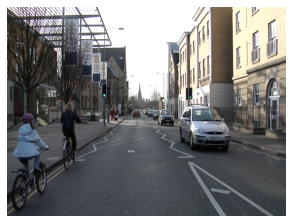

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))


Crearemos a continuación una función lambda para definir esta relación entre imágen rgb y su imágenes etiquetadas

Esta función labda se encarga de relacionar la imagen con su etiqueta, valiéndose de que ambas tienen el mismo nombre, solo que la de la etiqueta acaba en _P

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

A continuación nos disponemos a representar las etiquetas de la primera imagen (ver imagen superior) Utilizando la máscara somos capaces de visualizar la segmentación que fue llevada a cabo por los creadores del dataset para la imagen 1

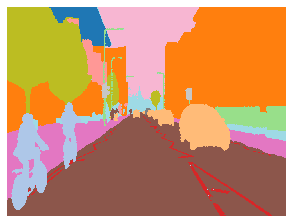

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)


En efecto la función ha permitido encontrar las etiquetas para la imagen [0]

Como podemos observar cada píxel de la imagen ha sido clasificado en numerosas categorías identificadas con colores distintos: paredes, ciclistas, coches, carretera, etcétera. Todos estos valores de píxeles son los que cogerá el modelo para aprender

Dentro de la carpeta raíz del dataset había, como hemos visto anteriormente, un fichero 'codes.txt', que contiene cada una de las categorías utilizadas. En la siguiente línea de código convertimos este fichero de texto en un numpy array, que será necesario para el entrenamiento

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Podemos ver por pantalla en el output anterior las distintas categorías identificadas. Resulta interesante saber que 'Void' son píxeles no clasificados

El dataset es demasiado grande para entrenar en un tiempo de cómputo reducido, así que se ha decidido reducir a la mitad su tamaño. Para ello primero se consulta el tamaño

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

En la siguiente línea de código guardamos en size el tamaño del dataset dividido entre 2 para reducir el tiempo de cómputo

In [ ]:
size = src_size//2
bs=8

Para el entrenamiento no usaremos el dataset entero, sólo se utilizará un montón o batch relativamente pequeño, ya que clasificar cada uno de los píxeles es una tarea que requiere una gran capacidad computacional con la que no se cuenta

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


En las líneas anteriores se ha creado un data bunch. Leyendo de arriba a abajo el código:

* Primero estamos creando un bunch (montón) de una carpeta, en este caso la carpeta que contiene los imágenes con las que entrenar el modelo (en el directorio 'path_img')
* En segundo lugar particionamos esa carpeta de imágenes entre entrenamiento y testeo basado en los nombres de los archivos contenidos en el fichero 'valid.txt'. Este fichero se encuentra en la carpeta raíz del dataset, junto a 'codes.txt'
* Lo siguiente que se hace es utilizar la función que se ha creado anteriormente para encontrar las etiquetas para cada una de las imágenes. Se pasa como parámetro la función que busca la imagen segmentada y como segundo parámetro el fichero 'codes.txt' que hemos guardado en 'codes'. Este segundo parámetro permite atribuir los nombres de las clases
* Por último se aplica una tranformación a las imágenes que según el estado del arte mejora los resultados obtenidos. es muy importante configurar tfm_y a True para que cualquier transformación que se le haga a una imagen se le haga también a su correspondiente imagen etiquetada

Con la siguiente línea de código podemos visualizar un fragmento del data batch que hemos creado, en el están solapadas las imágenes rgb y las etiquetas correspondientes

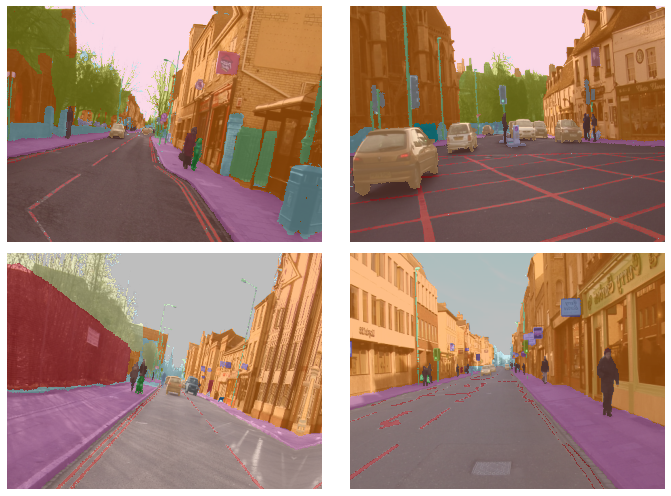

In [ ]:
data.show_batch(2, figsize=(10,7))

Podemos volver a ejecutar el mismo comando para ver otras fotos diferentes

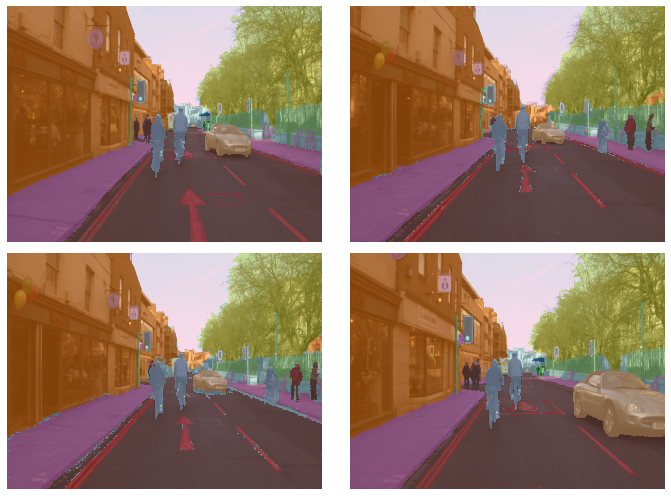

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

Ahora realizaremos el proceso de aprendizaje, utilizando una arquitectura 'unet_learner', que es el estado del arte en cuanto a segmentación de imágenes se refiere. En el siguiente enlace puede consultarse la documentación del mismo modelo : https://docs.fast.ai/vision.learner.html#create_unet_model
Al igual que el que se usó en los otros modelos, este también ha sido preentrenado con numerosas imágenes anteriormente para que sea más fácil de utilizar

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Se define la función ac_camvid que nos permite tener un valor de precisión, al igual que en problemas de clasificación (que en definitiva es lo que es): 

Precisión = nºaciertos de valor de píxel / nº total de píxeles

Como se ha dicho anteriormente algunos de los píxeles han sido definidos como 'Voids' (píxeles vacíos). Estos no deben ser considerados, es por esto que en la función filtramos con una máscara dichos píxeles vacíos para que no influyan en la precisión calculada

Esta función la introducimos en la variable 'metrics' (metrícas)

In [ ]:
metrics=acc_camvid

In [ ]:
wd=1e-2

En la siguiente línea de código creamos una instancia de la clase unet_learner, es decir, creamos nuestro modelo de IA y lo llamamos learn

Le pasamos como argumentos al modelo: 
* Nuestros datos de entrenamiento, que habíamos guardado en la variable data
* El tipo de arquitectura, en este caso resnet34 significa que es una red neuronal convolucional de 34 capas (layers)
* Pasamos también métricas que es la precisión que el modelo debe ir maximizando y el parámetro seleccionado para wd


In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Después de haber creado el objeto de clase vamos a intentar buscar los mejores parámetros para el aprendizaje

El siguiente código, mediante el empleo del método 'lr_find' busca encontrar los mejores parámetros para el entrenamiento

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


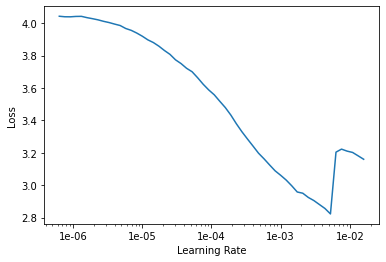

In [ ]:
lr_find(learn)
learn.recorder.plot()

La figura anterior muestra la tasa de aprendizaje, que puede darnos una idea de que valores podemos utilizar. Basado en el gráfico obtenido elegiremos los parámetros siguientes:

*** Este modelo requiere de mucho tiempo para entrenar (aproximadamente 20 minutos para 5 epochs) Lo ideal sería colocar el valor de 10 epoch pero demora mucho en el tiempo. Si lo que se quiere es obtener los mejores resultados se sugiere utilizar un valor mayor a 10 ya que el error desciende. No obstante con este número de epochs (5) se ha demostrado que las precisiones son más que aceptables. En el caso de querer entrenar rápidamente al modelo se sugiere utilizar un valor de 3 como mínimo ***

In [ ]:
learn.fit_one_cycle(5, slice(1e-06,1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.418313,0.953744,0.741427,04:15
1,0.919797,0.898725,0.790407,04:08
2,0.770014,0.674219,0.817756,04:07
3,0.660360,0.504772,0.862382,04:06
4,0.571894,0.392693,0.889815,04:05


Ahora que hemos entrenado nuestro modelo conviene guardar su estado, para poder a volver a él cuando sea necesario. Este primer estado será guardado con el método '.save' y con el nombre 'estado_1'

In [ ]:
learn.save('estado_1')

A continuación podemos ver mediante '.show_results' los resultados obtenidos, a la derecha aparecen los valores predichos y a la izquierda los reales. Como podemos observar las predicciones se acercan bastante a los valores reales. El modelo ha hecho unas buenas predicciones

Sin embargo se pueden observar ciertas deficiencias que podrían ser solventadas con un entrenamiento más prolongado o utilizando el dataset completo, en vez de la mitad

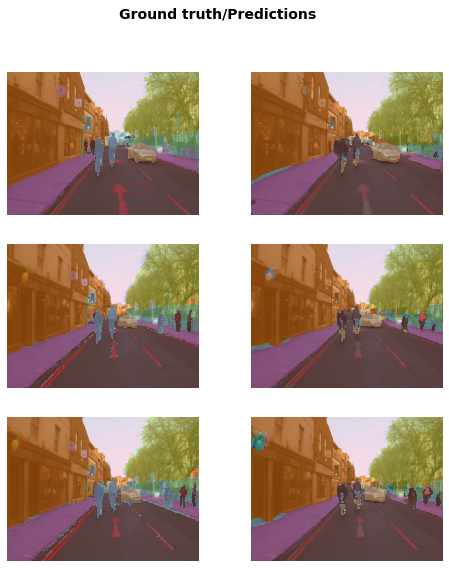

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

----------------------------------------------------------------------------